# ASSIGNMENT DUBIZZLE

## Given 2 Files - Sample Listings, Queries

### AIM- To Implement a simple approach to cluster the listings data into similar items clusters.

#### IMPORTS



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### READ THE FILES

In [27]:
df_queries =  pd.read_csv('olx_data_sample/za_queries_sample.csv')
df_queries.head(3)

,Unnamed: 0,search_term,cnt
0,0,polo,133394
1,1,golf,124172
2,2,isuzu,121043


In [3]:
df_queries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
Unnamed: 0     100000 non-null int64
search_term    99999 non-null object
cnt            100000 non-null int64
dtypes: int64(2), object(1)
memory usage: 2.3+ MB


In [4]:
df_listings = pd.read_csv('olx_data_sample/za_sample_listings_incl_cat.csv')
df_listings.head(3)

C:\Users\sleelag\AppData\Local\Continuum\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (0,2,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,item_id,seller_id,listing_title,listing_description,listing_price,category_sk,category_l1_name_en,category_l2_name_en,category_l3_name_en,listing_latitude,listing_longitude
0,0,0.0,0,Nice wooden makes,We build all different types for sale,17500.00,olx|mea|za|806|809,"Home, Garden & Tools",Garden & Braai,Unknown,-25.43067,27.84873
1,1,1.0,1,A Shinning 2013 Chevrolet 1.4 Utility Bakkie w...,A Stunning accident free bargain that has just...,94890.00,olx|mea|za|362|378|2012,Vehicles,Cars & Bakkies,Chevrolet,-29.73714,31.07364
2,2,2.0,2,Lampshades various,A variety of lampshades in white,20.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-33.88159,18.55522


In [5]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500016 entries, 0 to 500015
Data columns (total 12 columns):
Unnamed: 0             500008 non-null object
item_id                500012 non-null float64
seller_id              500012 non-null object
listing_title          500012 non-null object
listing_description    500012 non-null object
listing_price          491890 non-null object
category_sk            500000 non-null object
category_l1_name_en    500000 non-null object
category_l2_name_en    499988 non-null object
category_l3_name_en    499988 non-null object
listing_latitude       499988 non-null float64
listing_longitude      499988 non-null float64
dtypes: float64(3), object(9)
memory usage: 45.8+ MB


#### CHECKING MISSING VALUES 

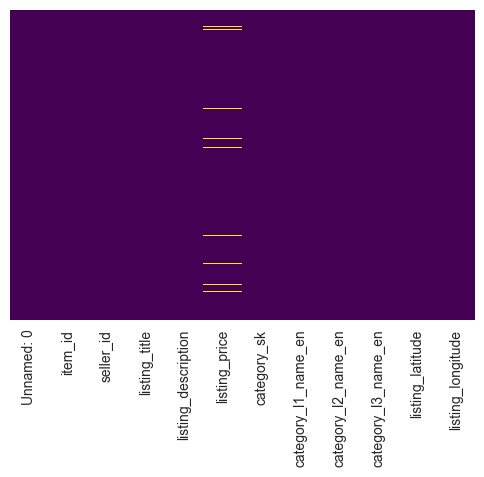

In [6]:
sns.heatmap(df_listings.isnull(),yticklabels=False,cbar=False,cmap='viridis')

#### UNDERSTANDING/CLEANING THE DATA PRESENT

#### 1)

In [129]:
df_listings['seller_id'].apply(lambda x: isinstance(x, (int, np.int64, float, np.float64))).value_counts()

False    368940
True     131076
Name: seller_id, dtype: int64

In [131]:
df_listings['seller_id'].apply(lambda x: isinstance(x, ( float, np.float64))).value_counts()

False    500012
True          4
Name: seller_id, dtype: int64

#### 2)

In [7]:
df_lp = df_listings[df_listings['listing_price'].isnull()]

In [8]:
df_lp['category_l1_name_en'].value_counts()

Jobs                    7147
Hobbies & Interests      696
Services                 229
Home, Garden & Tools      13
Fashion & Beauty           7
Office & Business          6
Property                   5
Sports & Outdoors          4
Farming & Industrial       2
Vehicles                   1
Name: category_l1_name_en, dtype: int64

**We understand that the missing values are very high for 'JOBS' category, followed by 'Hobbies & Interests' etcetera**

#### 4)

In [9]:
df_listings['category_l3_name_en'].nunique()

271

In [10]:
df_listings['category_l2_name_en'].nunique()

55

In [11]:
df_listings['category_l1_name_en'].nunique()
df_listings['category_l1_name_en'].value_counts()

Vehicles                   222198
Electronics & Computers     74478
Home, Garden & Tools        61722
Services                    28892
Property                    19753
Sports & Outdoors           15712
Hobbies & Interests         15178
Fashion & Beauty            14449
Farming & Industrial        14376
Pets                        11337
Office & Business            8146
Jobs                         7277
Kids & Baby                  6470
28.21173000                     3
28.00690000                     1
28.04731000                     1
18.42406000                     1
26.23637000                     1
28.50514000                     1
28.70814000                     1
28.00104000                     1
28.22927000                     1
27.92563000                     1
Name: category_l1_name_en, dtype: int64

In [12]:
threshold = 10 
value_counts = df_listings['category_l1_name_en'].value_counts() # Entire DataFrame 
to_remove = value_counts[value_counts <= threshold].index
df_listings.replace(to_remove, np.nan, inplace=True)


#### 5)

POints to be noted / Items which could be taken care of:

1. Data type conflicts in 3 cols
2. Impute the listing price with avg values
3. Currently assuming that LATITUE,LONGITUDE features are less important features

#### NEED TO MERGE THE 2 FILES - LISTINGS AND QUERIES 

We cannot directly merge these 2 files because there is no common key in between these 2 files

Hence we will use COSINE SIMILARITY to match SEARCH_ITEMS to their most relevant CATEGORIES  


In [13]:
listing_catl1 = df_listings['category_l1_name_en'].values.tolist()
listing_catl2 = df_listings['category_l2_name_en'].values.tolist()
listing_catl3 = df_listings['category_l3_name_en'].values.tolist()

In [14]:
queries_ls = df_queries['search_term'].values.tolist()

In [15]:
## FUNCTION TO CALCULATE COSINE SIMILARITY

import re
import math
from collections import Counter


def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection])

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2)

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator


def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)


def get_result(content_a, content_b):
    text1 = content_a
    text2 = content_b

    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)

    cosine_result = get_cosine(vector1, vector2)
    return cosine_result


In [ ]:
# Creating a file for Category-l3 searches
for i in set(listing_catl3):
    call2_searchq_str = ''
    for j in queries_ls:        
        if get_result(str(i).lower(),(str(j)).lower())> 0.65:
            #print(str(i) + ':' + str(j))
            call3_searchq_str = str(i) + ':' + str(j) + '\n' 
            myfile = open('catl3_searchq.txt', "a")
            myfile.write(call3_searchq_str)

In [ ]:
# Creating a file for Category-l2 searches
for i in set(listing_catl2):
    call2_searchq_str = ''
    for j in queries_ls:        
        if get_result(str(i).lower(),(str(j)).lower())> 0.65:
            #print(str(i) + ':' + str(j))
            call2_searchq_str = str(i) + ':' + str(j) + '\n' 
            myfile = open('catl2_searchq.txt', "a")
            myfile.write(call2_searchq_str)

In [17]:
df_cat13_searchq = pd.read_csv('catl3_searchq.txt',sep= ':' , encoding='utf-8', names = ['category_l3_name_en', 'search_term'] )

In [19]:
df_cat13_searchq.head()

,category_l3_name_en,search_term
0,catl3,search_term
1,Hummer,hummer
2,Hummer,hummer h3
3,Hummer,hummer h2
4,Hummer,hummer h1


In [18]:
df_cat12_searchq = pd.read_csv('catl2_searchq.txt',sep= ':' , names = ['category_l2_name_en', 'search_term'] )

In [20]:
df_cat12_searchq.head()

,category_l2_name_en,search_term
0,catl2,search_term
1,Boats & Aviation,boats
2,Boats & Aviation,aviation
3,Boats & Aviation,boats boats
4,Boats & Aviation,boats and aviation


#### MERGING -  'df_cat12/3_searchq' WITH 'df_queries' TO GET COUNT

In [29]:
#df_queries.drop('Unnamed: 0', axis = 1, inplace= True)
df_queries.head()

,search_term,cnt
0,polo,133394
1,golf,124172
2,isuzu,121043
3,bmw,109099
4,toyota corolla,107486


In [30]:
df_catl3 = pd.merge(df_cat13_searchq, df_queries, on='search_term')

In [31]:
df_catl2 = pd.merge(df_cat12_searchq, df_queries, on='search_term')

In [32]:
df_catl2.head()

,category_l2_name_en,search_term,cnt
0,Boats & Aviation,boats,18673
1,Boats & Aviation,aviation,451
2,Boats & Aviation,boats boats,46
3,Boats & Aviation,boats and aviation,38
4,Boats & Aviation,boats.,22


In [34]:
#Create a new df -> which has the the list of the L3 categories with count

df_catl3_queries_cnt = pd.DataFrame({'cnt' : df_catl3.groupby( 'category_l3_name_en' ).size()}).reset_index()

In [158]:
df_catl3_queries_cnt.head()
#df_catl3_queries_cnt.info()

,category_l3_name_en,cnt,catl3_ID
0,Accord,5,1
1,Adly,2,2
2,Aeon,4,3
3,Agco / Massey Ferguson,44,4
4,Airstream,2,5


In [156]:
df_catl3_queries_cnt['catl3_ID'] = np.arange(1,206)

In [159]:
# Now merging the Main df with the catl3 - queries count df_catl3_queries_cnt- dataframe

df_main_catl3 = pd.merge(df_listings, df_catl3_queries_cnt,how='left', on='category_l3_name_en')

In [160]:
#Create a new df -> which has the the list of the L2 categories with count

df_catl2_queries_cnt = pd.DataFrame({'cnt' : df_catl2.groupby( 'category_l2_name_en' ).size()}).reset_index()


In [161]:
df_catl2_queries_cnt.columns = ['category_l2_name_en', 'cnt2']


In [165]:
df_catl2_queries_cnt['catl2_ID'] = np.arange(1,53)

In [166]:
df_catl2_queries_cnt.head()
df_catl2_queries_cnt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 3 columns):
category_l2_name_en    52 non-null object
cnt2                   52 non-null int64
catl2_ID               52 non-null int32
dtypes: int32(1), int64(1), object(1)
memory usage: 1.1+ KB


In [167]:
#  Now merging the Main df_listing with the cal2 - queries count df_catl2_queries_cnt- dataframe

df_main_catl2 = pd.merge(df_main_catl3, df_catl2_queries_cnt,how='left', on='category_l2_name_en')


In [168]:
df_main_catl2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500016 entries, 0 to 500015
Data columns (total 16 columns):
Unnamed: 0             500008 non-null object
item_id                500012 non-null float64
seller_id              500012 non-null object
listing_title          500012 non-null object
listing_description    500012 non-null object
listing_price          491890 non-null object
category_sk            500000 non-null object
category_l1_name_en    499988 non-null object
category_l2_name_en    499988 non-null object
category_l3_name_en    499988 non-null object
listing_latitude       499988 non-null float64
listing_longitude      456579 non-null float64
cnt                    182084 non-null float64
catl3_ID               182084 non-null float64
cnt2                   492785 non-null float64
catl2_ID               492785 non-null float64
dtypes: float64(7), object(9)
memory usage: 64.9+ MB


In [171]:
df_main_catl2['category_l23_name'] = df_main_catl2.apply(
    lambda row: row['category_l2_name_en'] if row['category_l3_name_en']== 'Unknown' else row['category_l3_name_en'],
    axis=1
)

In [172]:
df_main_catl2['category_l23_name'].nunique()

321

In [173]:
df_main_catl2['category_l3_name_en'].nunique()

271

In [174]:
df_main_catl2['category_l23_name'].value_counts()

Car Parts & Accessories            37307
Furniture & Decor                  31555
Toyota                             30718
Volkswagen                         28651
Cell Phones                        28266
Homeware & Appliances              15303
Other                              13931
Ford                               12544
Construction & Home Improvement    12153
Gaming & Consoles                  11468
TV, Audio & Visual                 11323
Computers & Laptops                10876
BMW                                 9999
Opel                                9966
Outdoor & Sports Equipment          9465
Nissan                              9375
Houses & Flats for rent             9333
Tools & DIY                         9162
Mercedes-Benz                       7651
Other Services                      7334
Dogs & Cats                         7170
Business & Industrial Equipment     6871
Hyundai                             6702
Clothing & Shoes                    6694
Computer Hardwar

In [175]:
## Proceding with building the model using combining cnt + cnt2 values
## Creating the final df

df_main_catl2['cnt'].fillna(0, inplace=True)

df_main_catl2['query_count'] = df_main_catl2['cnt'] + df_main_catl2['cnt2']

In [176]:
df_final = df_main_catl2[[ 'seller_id','category_l23_name', 'query_count']]

In [177]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500016 entries, 0 to 500015
Data columns (total 3 columns):
seller_id            500012 non-null object
category_l23_name    499988 non-null object
query_count          492785 non-null float64
dtypes: float64(1), object(2)
memory usage: 15.3+ MB


In [178]:
#df_final.dropna(inplace=True)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500016 entries, 0 to 500015
Data columns (total 3 columns):
seller_id            500012 non-null object
category_l23_name    499988 non-null object
query_count          492785 non-null float64
dtypes: float64(1), object(2)
memory usage: 15.3+ MB


#### CREATING THE PRODUCT MATRIX

In [179]:
df_final['query_count'].nunique()
df_final['category_l23_name'].value_counts()


Car Parts & Accessories            37307
Furniture & Decor                  31555
Toyota                             30718
Volkswagen                         28651
Cell Phones                        28266
Homeware & Appliances              15303
Other                              13931
Ford                               12544
Construction & Home Improvement    12153
Gaming & Consoles                  11468
TV, Audio & Visual                 11323
Computers & Laptops                10876
BMW                                 9999
Opel                                9966
Outdoor & Sports Equipment          9465
Nissan                              9375
Houses & Flats for rent             9333
Tools & DIY                         9162
Mercedes-Benz                       7651
Other Services                      7334
Dogs & Cats                         7170
Business & Industrial Equipment     6871
Hyundai                             6702
Clothing & Shoes                    6694
Computer Hardwar

In [180]:
productmat = df_final.pivot_table(index='seller_id',columns='category_l23_name',values='query_count')
productmat.head()


category_l23_name,ABG,Accord,Ackermann,Adly,Adria,Aeon,Agados,Agco / Massey Ferguson,Ahlmann,Ahorn,...,Weippert,Wilk,Yamaha,Yanmar,Zetor,Zettelmeyer,Zhongyu,Zündapp,e-max,iPads & Tablets
seller_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
productmat = productmat[np.isfinite(productmat['Toyota'])]
productmat.head()

category_l23_name,ABG,Accord,Ackermann,Adly,Adria,Aeon,Agados,Agco / Massey Ferguson,Ahlmann,Ahorn,...,Weippert,Wilk,Yamaha,Yanmar,Zetor,Zettelmeyer,Zhongyu,Zündapp,e-max,iPads & Tablets
seller_id,,,,,,,,,,,,,,,,,,,,,
811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,689.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,689.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,689.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,689.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,689.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
n_sellers = df_final['seller_id'].nunique()
n_items = df_final['category_l23_name'].nunique()
sparsity=round(1.0-len(df_final)/float(n_sellers*n_items),3)
sparsity

0.992

In [69]:
df_queries.sort_values('cnt',ascending=False).head(10)

,search_term,cnt
0,polo,133394
1,golf,124172
2,isuzu,121043
3,bmw,109099
4,toyota corolla,107486
5,toyota,99802
6,hilux,95592
7,toyota tazz,94877
8,cars,93824
9,bakkie,89243


In [118]:
cameras_queries = productmat['Toyota']
cameras_queries.head()

seller_id
811      1902.0
1241     1902.0
2677     1902.0
6276     1896.0
18105    1902.0
Name: Toyota, dtype: float64

In [119]:
## We can then use corrwith() method to get correlations between two pandas series:

similar_to_cameras = productmat.corrwith(cameras_queries)
similar_to_cameras

C:\Users\sleelag\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\sleelag\AppData\Local\Continuum\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


category_l23_name
ABG                             NaN
Accord                          NaN
Ackermann                       NaN
Adly                            NaN
Adria                           NaN
Aeon                            NaN
Agados                          NaN
Agco / Massey Ferguson          NaN
Ahlmann                         NaN
Ahorn                           NaN
Airstream                       NaN
Aixam                           NaN
Alfa Romeo                      NaN
Algema                          NaN
Aliner                          NaN
Alpha                           NaN
Amazone                         NaN
Americana                       NaN
Ammann                          NaN
Anssems                         NaN
Aprilia                         NaN
Arca                            NaN
Arctic Cat                      NaN
Asia Wolf                       NaN
Aston Martin                    NaN
Atlas                           NaN
Audi                            NaN
Autostar  

In [120]:
##Let's clean this by removing NaN values and using a DataFrame instead of a series:
corr_cameras = pd.DataFrame(similar_to_cameras,columns=['Correlation'])
#corr_cameras.dropna(inplace=True)
corr_cameras = corr_cameras[np.isfinite(corr_cameras['Correlation'])]
corr_cameras.head()


,Correlation
category_l23_name,
Honda,0.166667
Mercedes-Benz,1.000000
Toyota,1.000000


### SVD 


#### Matrix factorization method is Singular value decomposition (SVD). Collaborative Filtering can be formulated by approximating a matrix X by using singular value decomposition.

In [181]:
df_main_catl2['seller_id'].apply(lambda x: isinstance(x, ( float, np.float64))).value_counts()

False    500012
True          4
Name: seller_id, dtype: int64

In [194]:
## Combining catl2 + catl3 values
## Creating the final df

df_main_catl2['catl2_ID'].fillna(0, inplace=True)
df_main_catl2['catl3_ID'].fillna(0, inplace=True)
#df_main_catl2['query_count'] = df_main_catl2['cnt'] + df_main_catl2['cnt2']

In [220]:
#df_main_catl2['catl2_ID'].map(int)
#df_main_catl2['catl3_ID'].map(int)

df_main_catl2[['catl2_ID','catl3_ID']] = df_main_catl2[['catl2_ID','catl3_ID']].astype(int)

#df_main_catl2.head()

In [211]:
df_main_catl2['cat_ID'] = df_main_catl2['catl2_ID'].map(str)  + df_main_catl2['catl3_ID'].map(str)

In [212]:
df_main_catl2.head()

,Unnamed: 0,item_id,seller_id,listing_title,listing_description,listing_price,category_sk,category_l1_name_en,category_l2_name_en,category_l3_name_en,listing_latitude,listing_longitude,cnt,catl3_ID,cnt2,catl2_ID,cat_ID,category_l23_name,query_count
0,0,0.0,0,Nice wooden makes,We build all different types for sale,17500.00,olx|mea|za|806|809,"Home, Garden & Tools",Garden & Braai,Unknown,-25.43067,27.84873,0.0,0,9.0,24,240,Garden & Braai,9.0
1,1,1.0,1,A Shinning 2013 Chevrolet 1.4 Utility Bakkie w...,A Stunning accident free bargain that has just...,94890.00,olx|mea|za|362|378|2012,Vehicles,Cars & Bakkies,Chevrolet,-29.73714,31.07364,258.0,40,20.0,11,1140,Chevrolet,278.0
2,2,2.0,2,Lampshades various,A variety of lampshades in white,20.00,olx|mea|za|806|807,"Home, Garden & Tools",Furniture & Decor,Unknown,-33.88159,18.55522,0.0,0,9.0,22,220,Furniture & Decor,9.0
3,3,3.0,3,Toyota Corolla,"Toyota Corolla 1.3 Professional, Front Electri...",63995.00,olx|mea|za|362|378|2067,Vehicles,Cars & Bakkies,Toyota,-26.10757,28.05670,1882.0,190,20.0,11,11190,Toyota,1902.0
4,4,4.0,4,bench grinder and buffer,bench grinder and.buffer...R800 for both,800.00,olx|mea|za|806|910,"Home, Garden & Tools",Tools & DIY,Unknown,-26.17190,27.91318,0.0,0,10.0,47,470,Tools & DIY,10.0


In [257]:
df_main_catl2.columns
#df_main_catl2.info()

df_final_svd = df_main_catl2[[ 'cat_ID', 'seller_id','query_count','category_l23_name' ]]

In [259]:
#df_final_svd['cat_ID'] = df_final_svd['cat_ID'].astype(int)
#df_final_svd['seller_id'] = df_final_svd['seller_id'].astype(int)
df_final_svd.dropna(inplace= True)
df_final_svd[df_final_svd['seller_id'].apply(lambda x: isinstance(x, ( float, np.float64)))]
df_final_svd['seller_id'] = df_final_svd['seller_id'].astype(int)
df_final_svd['cat_ID'] = df_final_svd['cat_ID'].astype(int)
df_final_svd.info()

C:\Users\sleelag\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 492785 entries, 0 to 500015
Data columns (total 4 columns):
cat_ID               492785 non-null int32
seller_id            492785 non-null int32
query_count          492785 non-null float64
category_l23_name    492785 non-null object
dtypes: float64(1), int32(2), object(1)
memory usage: 15.0+ MB


C:\Users\sleelag\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\sleelag\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [260]:
df_final_svd.head()

,cat_ID,seller_id,query_count,category_l23_name
0,240,0,9.0,Garden & Braai
1,1140,1,278.0,Chevrolet
2,220,2,9.0,Furniture & Decor
3,11190,3,1902.0,Toyota
4,470,4,10.0,Tools & DIY


In [261]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(df_final_svd, test_size=0.25)

In [282]:
n_sellers = df_final_svd['seller_id'].nunique()
n_items = df_final_svd['category_l23_name'].nunique()

n_sellers = 15500
n_items = 118000
print('Num. of Sellers: '+ str(n_sellers))
print('Num of Items: '+ str(n_items))

Num. of Sellers: 15500
Num of Items: 118000


In [ ]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_sellers, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_sellers, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

In [ ]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

#### STOPPING HERE DUE TO TIME CONSTRAINT!



#### Evaluate :

** RMSE : To evaluate accuracy of predicted rating. **

#### Different from Naive approach :


** 1) Here we are recommending based on the correaltion of each values in the product matrix ** 

** 2) Also considering the SVD implementation -  Memory-based CF - Matrix factorization (MF). ** 


#### Improvements
There are many improvements possible with above model:

 
** 1) More preprocessing of the data ** 

** 2) Normalising the Queries count field** 

** 3) Use main categories(mentioned in website)for creating clusters of main category and then proceed with recommendation** 

** 4) Build a hybrid model - Collaborative Filtering and Content-based Models  combined** 



